# 8. Pre-trained Models Benchmarking

Benchmark custom convolutional models against other well known top-performing pre-trained CNN models

## 8.1 Import Libraries

In [2]:
import os, sys, random, gc, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import StringIO

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.backend import clear_session
from tensorflow.errors import ResourceExhaustedError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

2024-02-12 06:19:59.912765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 06:20:00.817275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 8.2 Load Sorted Data

In [4]:
def get_image_paths(data_dir):
    image_paths = []
    for root, dirs, files in os.walk(data_dir):
        if set('junk' in root.split(os.sep):
            # Skip 'junk' folder
            continue
        # Iterate 'non-junk' files in folder
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_image_paths("../02. Datasets/Images")
df = pd.DataFrame(image_paths, columns=['image_path'])
df['class'] = df['image_path'].apply(lambda x: x.split('/')[-2])

print(len(image_paths))
image_paths[0:2]

17939


['../02. Datasets/Images/Erythrasma/link.springer.com_en_18.jpg',
 '../02. Datasets/Images/Erythrasma/facebook.com_en_6.jpg']

## 8.3 Pre-processing

### 8.3.1 Class Balancing

In [5]:
# Filter out classes with too little samples (min. 2 samples per class is needed for stratify split)
class_counts = df['class'].value_counts()
retain_classes = class_counts[class_counts > 10].index
df = df[df['class'].isin(retain_classes)]
label_encoder = LabelEncoder()
label_encoder.fit(df['class'].unique())
print(f"Classes: {len(label_encoder.classes_)}")

Classes: 71


In [6]:
print(df['class'].value_counts())

class
Dermatitis, Atopic               997
Pityriasis Rosea                 787
Dermatitis, Seborrheic           676
Keratosis, Seborrheic            550
Alopecia Areata                  547
                                ... 
Chloracne                         59
Carbuncle                         58
Necrolytic Migratory Erythema     57
Porokeratosis                     52
Porphyria Cutanea Tarda           52
Name: count, Length: 71, dtype: int64


### 8.3.2 Split into Train(80)/Validation(10)/Test(10) sets

In [7]:
# Split into train & test set
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=16)

# Further split the train set into train & validation set
train_df, val_df = train_test_split(train_df, test_size=0.1111111111111111, stratify=train_df['class'], random_state=16) # 0.25 x 0.8 = 0.2

In [8]:
def generate_split_report(train_df, val_df, test_df):
    # Calculate counts for each class in each dataset
    train_counts = train_df['class'].value_counts()
    val_counts = val_df['class'].value_counts()
    test_counts = test_df['class'].value_counts()

    # Number of unique classes in each set
    unique_classes_train = len(train_counts)
    unique_classes_val = len(val_counts)
    unique_classes_test = len(test_counts)

    # Print unique classes to confirm if class sizes across sets are equal
    print(f"Classes in Train set: {unique_classes_train}")
    print(f"Classes in Validation set: {unique_classes_val}")
    print(f"Classes in Test set: {unique_classes_test}")
    
    # Create a DataFrame from the counts
    distribution_df = pd.DataFrame({
        'Class': train_counts.index,
        'Train': train_counts.values,
        'Validation': val_counts[train_counts.index].values,
        'Test': test_counts[train_counts.index].values
    })

    return distribution_df

split_report_df = generate_split_report(train_df, val_df, test_df)
split_report_df

Classes in Train set: 71
Classes in Validation set: 71
Classes in Test set: 71


,Class,Train,Validation,Test
0,"Dermatitis, Atopic",797,100,100
1,Pityriasis Rosea,629,79,79
2,"Dermatitis, Seborrheic",540,68,68
3,"Keratosis, Seborrheic",440,55,55
4,Alopecia Areata,437,55,55
...,...,...,...,...
66,Serum Sickness,47,6,6
67,Carbuncle,46,6,6
68,Necrolytic Migratory Erythema,45,6,6
69,Porokeratosis,42,5,5


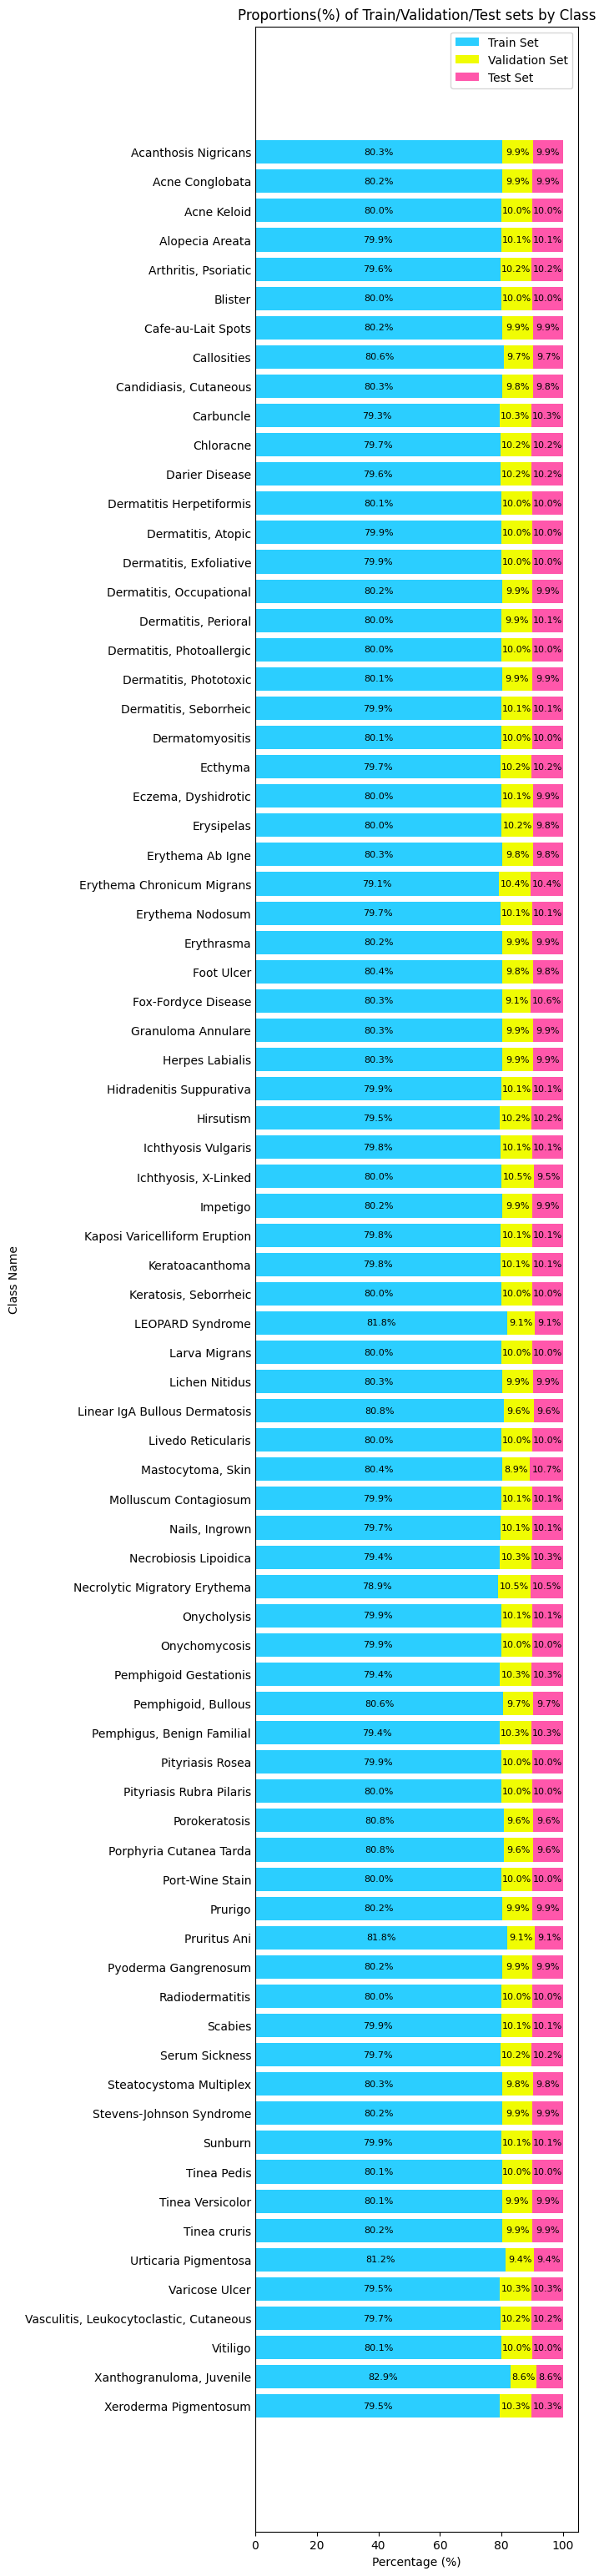

In [8]:
def plot_stacked_bar_chart(df):
    df = df.copy()
    df = df.sort_values('Class', ascending=False)
    df['totalCount'] = df['Train'] + df['Validation'] + df['Test']
    df['trainPercent'] = df['Train'] / df['totalCount'] * 100
    df['validationPercent'] = df['Validation'] / df['totalCount'] * 100
    df['testPercent'] = df['Test'] / df['totalCount'] * 100
    height_per_class = 0.5
    total_classes = len(df['Class'])
    fig_height = height_per_class * total_classes
    fig, ax = plt.subplots(figsize=(5, fig_height))

    # Add labels & title
    ax.set_title('Proportions(%) of Train/Validation/Test sets by Class')
    ax.set_xlabel('Percentage (%)')
    ax.set_ylabel('Class Name')
    ax.tick_params(axis='y', length=0)
    bars_train = ax.barh(df['Class'], df['trainPercent'], color='#2bceff', label='Train Set')
    bars_validation = ax.barh(df['Class'], df['validationPercent'], color='#f0fc03', left=df['trainPercent'], label='Validation Set')
    bars_test = ax.barh(df['Class'], df['testPercent'], color='#ff57ab', left=df['trainPercent'] + df['validationPercent'], label='Test Set')

    # Annotate bars with (%) values
    for bars in [bars_train, bars_validation, bars_test]:
        for bar in bars:
            if bar.get_width() > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                        f"{bar.get_width():.1f}%", va='center', ha='center', color='black', fontsize=8)
    ax.legend()
    plt.show()

plot_stacked_bar_chart(split_report_df)

## 8.4 Deep Learning

### 8.4.1 Configurations

In [9]:
# --- Classes --- 
NUM_CLASSES = len(label_encoder.classes_)  # total number of unique classes to predict

# --- Training Configurations ---
LOSS_FUNCTION = 'categorical_crossentropy'  # for multi-class single-label problems
LAST_LAYER_ACTIVATION = 'softmax'           # for multi-class single-label problems. convert logits to probabilities by normalizing output to a probability distribution over output classes
LEARNING_RATE = 0.001
OPTIMIZER = 'adam'

# --- Callbacks ---
class CallbacksManager:
    def get_callbacks(self):
        # Schedule learning rate - to dynamically adjust learning rate based on rate of change in validation loss during training
        LR_SCHEDULER = ReduceLROnPlateau(
            monitor='val_loss',   # reduce learning rate when validation loss metric stopped improving
            factor=0.1, 
            patience=5,
            min_lr=0.00001, 
            verbose=1
        )
        
        # Stop training early, to reduce over-fitting
        EARLY_STOP = EarlyStopping(
            monitor='val_loss',
            patience=10
        )
        
        return [LR_SCHEDULER, EARLY_STOP]
CALLBACKSmanager = CallbacksManager()

# --- Optimizer ---  to optimize adaptive learning rate
class OptimizerManager:
    def get_optimizer(self, optimizer_name, learning_rate):
        if optimizer_name == 'adam':
            return Adam(learning_rate=learning_rate)    # general choice - suit most cases
        elif optimizer_name == 'sgd':
            return SGD(learning_rate=learning_rate)     # classic choice - suit simple models with small datasets
        elif optimizer_name == 'rmsprop':
            return RMSprop(learning_rate=learning_rate) # adaptive choice - suit problems with noisy or non-stationary data
        else:
            raise ValueError("No such optimizer")
            
OPTIMIZERMANAGER = OptimizerManager()

# --- Performance Evaluation Metrics ---
EVALUATION_METRICS = ['accuracy', Precision(name='precision'), Recall(name='recall')]

2024-02-12 06:20:40.412537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:20:40.558253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:20:40.558312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:20:40.559940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:20:40.559991: I tensorflow/compile

### 8.4.2 Pre_trained Models Compilation

In [10]:
global_pretrained_CNN_histories = {}
global_pretrained_stack_summaries = {}
global_pretrained_test_predictions = {}

In [11]:
class Pre_Trained_CNN:
    def __init__(self, model_name, config):
        self.model_name = model_name
        self.config = config
        self.base_model, self.model = self._create_model()

    def _create_model(self):
        # Initialize base model based on selected architecture with pre-trained weights
        if self.model_name == 'VGG16':
            base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, 
                input_shape=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH'], self.config['TARGET_IMG_COLOR_CHANNELS']))
        elif self.model_name == 'ResNet50':
            base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, 
                input_shape=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH'], self.config['TARGET_IMG_COLOR_CHANNELS']))
        elif self.model_name == 'MobileNet':
            base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, 
                input_shape=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH'], self.config['TARGET_IMG_COLOR_CHANNELS']))
        elif self.model_name == 'Xception':
            base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, 
                input_shape=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH'], self.config['TARGET_IMG_COLOR_CHANNELS']))
        elif self.model_name == 'InceptionV3':
            base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, 
                input_shape=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH'], self.config['TARGET_IMG_COLOR_CHANNELS']))
        else:
            raise ValueError('Unsupported model: ' + self.model_name)
            
        base_model.trainable = not self.config['fine_tune']
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(NUM_CLASSES, activation=LAST_LAYER_ACTIVATION)(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        return base_model, model

    def compile(self):
        self.model.compile(
            optimizer=OPTIMIZERMANAGER.get_optimizer(OPTIMIZER, LEARNING_RATE),
            loss=LOSS_FUNCTION,
            metrics=EVALUATION_METRICS
        )

    def _create_data_generators(self):
        # Create a new pre-processor suitable for each model
        if self.model_name == 'VGG16':
            from tensorflow.keras.applications.vgg16 import preprocess_input
        elif self.model_name == 'MobileNet':
            from tensorflow.keras.applications.mobilenet import preprocess_input
        elif self.model_name == 'InceptionV3':
            from tensorflow.keras.applications.inception_v3 import preprocess_input
        elif self.model_name == 'ResNet50':
            from tensorflow.keras.applications.resnet50 import preprocess_input
        elif self.model_name == 'Xception':
            from tensorflow.keras.applications.xception import preprocess_input
        else:
            raise ValueError('Unsupported model: ' + self.model_name)
        imageDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
        train_generator = imageDataGenerator.flow_from_dataframe(
            dataframe=train_df,
            x_col='image_path',
            y_col='class',
            target_size=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH']),
            batch_size=self.config['TARGET_BATCH_SIZE'],
            class_mode='categorical',
            drop_remainder=True
        )
        validation_generator = imageDataGenerator.flow_from_dataframe(
            dataframe=val_df,
            x_col='image_path',
            y_col='class',
            target_size=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH']),
            batch_size=self.config['TARGET_BATCH_SIZE'],
            class_mode='categorical',
            drop_remainder=True
        )
        test_generator = imageDataGenerator.flow_from_dataframe(
            dataframe=test_df,
            x_col='image_path',
            y_col='class',
            target_size=(self.config['TARGET_IMG_HEIGHT'], self.config['TARGET_IMG_WIDTH']),
            batch_size=self.config['TARGET_BATCH_SIZE'],
            class_mode='categorical',
            shuffle=False,
            drop_remainder=True
        )
        return train_generator, validation_generator, test_generator
    
    def train(self):
        train_generator, validation_generator, _ = self._create_data_generators()
        self.base_model.trainable = False
        history = self.model.fit(train_generator, epochs=self.config['EPOCHS'], validation_data=validation_generator, callbacks=CALLBACKSmanager.get_callbacks())
        global_pretrained_CNN_histories[self.model_name] = {'pre_fineTune': history.history}
        if self.config['fine_tune']:
            self.base_model.trainable = True
            for layer in self.base_model.layers[:self.config['fine_tune_from_layer']]:
                layer.trainable = False
            self.model.compile(
                optimizer=OPTIMIZERMANAGER.get_optimizer(OPTIMIZER, LEARNING_RATE / 10),
                loss=LOSS_FUNCTION,
                metrics=EVALUATION_METRICS
            )
            fine_tune_history = self.model.fit(train_generator, epochs=self.config['EPOCHS_FINE_TUNE'], validation_data=validation_generator, callbacks=CALLBACKSmanager.get_callbacks())
            global_pretrained_CNN_histories[self.model_name]['post_fineTune'] = fine_tune_history.history

    def evaluate(self):
        _, _, test_generator = self._create_data_generators()
        test_results = self.model.evaluate(test_generator)
        if len(test_results) >= 4:
            precision = test_results[2]
            recall = test_results[3]
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
            test_results.append(f1_score)      
        global_pretrained_CNN_histories[self.model_name]['test_history'] = test_results
        test_generator.reset()
        steps = len(test_generator)
        preds = self.model.predict(test_generator, steps=steps)
        test_predictions = np.argmax(preds, axis=1)
        test_true_labels = test_generator.classes
        global_pretrained_test_predictions[self.model_name] = {
            "predictions": test_predictions,
            "true_labels": test_true_labels,
        }
        return test_results
        
    def summary(self):
        self.model.summary()

# Function to record summary of model stack
def record_modelStack_summary(model, model_name):
    old_stdout = sys.stdout
    sys.stdout = buffer = StringIO()
    model.summary()
    sys.stdout = old_stdout
    global_pretrained_stack_summaries[model_name] = buffer.getvalue()

### 8.4.3 Train/Validate/Test Multiple Pre_trained Models at the same time, in sequence

In [12]:
# --- Configurations ---
pre_trained_models_configuration = {
    # 16 layers
    'VGG16': {
        'run': 1,
        'fine_tune': 1, 
        'fine_tune_from_layer': 11,
        'EPOCHS': 20, 'EPOCHS_FINE_TUNE': 20,
        'TARGET_IMG_WIDTH': 224, 'TARGET_IMG_HEIGHT': 224, 'TARGET_IMG_COLOR_CHANNELS': 3 ,
        'TARGET_BATCH_SIZE': 32
    },
    # 28 layers
    'MobileNet': {
        'run': 1,
        'fine_tune': 1, 
        'fine_tune_from_layer': 20,
        'EPOCHS': 20, 'EPOCHS_FINE_TUNE': 20,
        'TARGET_IMG_WIDTH': 224, 'TARGET_IMG_HEIGHT': 224, 'TARGET_IMG_COLOR_CHANNELS': 3 ,
        'TARGET_BATCH_SIZE': 64
    },
    # 48 main modules
    'InceptionV3': {
        'run': 1,
        'fine_tune': 1,
        'fine_tune_from_layer': 34,
        'EPOCHS': 20, 'EPOCHS_FINE_TUNE': 20,
        'TARGET_IMG_WIDTH': 299, 'TARGET_IMG_HEIGHT': 299, 'TARGET_IMG_COLOR_CHANNELS': 3 ,
        'TARGET_BATCH_SIZE': 32
    },
    # 50 layers
    'ResNet50': {
        'run': 1,
        'fine_tune': 1, 
        'fine_tune_from_layer': 36,
        'EPOCHS': 20, 'EPOCHS_FINE_TUNE': 20,
        'TARGET_IMG_WIDTH': 224, 'TARGET_IMG_HEIGHT': 224, 'TARGET_IMG_COLOR_CHANNELS': 3 ,
        'TARGET_BATCH_SIZE': 32
    },
    # 71 layers
    'Xception': {
        'run': 1,
        'fine_tune': 1, 
        'fine_tune_from_layer': 50,
        'EPOCHS': 20, 'EPOCHS_FINE_TUNE': 20,
        'TARGET_IMG_WIDTH': 299, 'TARGET_IMG_HEIGHT': 299, 'TARGET_IMG_COLOR_CHANNELS': 3 ,
        'TARGET_BATCH_SIZE': 32
    }
}

In [13]:
# Train and evaluate all pre-trained models
for modelName, config in pre_trained_models_configuration.items():
    if config['run']:
        model = Pre_Trained_CNN(modelName, config)
        model.compile()
        model.train()
        model.evaluate()
        record_modelStack_summary(model.model, modelName)

Found 14351 validated image filenames belonging to 71 classes.
Found 1794 validated image filenames belonging to 71 classes.
Found 1794 validated image filenames belonging to 71 classes.
Epoch 1/20


2024-02-12 06:21:25.597498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-02-12 06:21:28.299538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-12 06:21:28.350211: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f27940303e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 06:21:28.350252: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-12 06:21:28.368500: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 06:21:28.536762: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

449/449 [==============================] - 72s 152ms/step - loss: 3.2509 - accuracy: 0.2376 - precision: 0.5046 - recall: 0.0801 - val_loss: 2.7668 - val_accuracy: 0.3016 - val_precision: 0.6503 - val_recall: 0.1109 - lr: 0.0010
Epoch 2/20
449/449 [==============================] - 61s 136ms/step - loss: 2.2964 - accuracy: 0.3990 - precision: 0.6966 - recall: 0.2027 - val_loss: 2.7436 - val_accuracy: 0.3305 - val_precision: 0.5783 - val_recall: 0.1873 - lr: 0.0010
Epoch 3/20
449/449 [==============================] - 62s 137ms/step - loss: 1.8439 - accuracy: 0.5037 - precision: 0.7458 - recall: 0.3090 - val_loss: 2.6809 - val_accuracy: 0.3579 - val_precision: 0.5745 - val_recall: 0.2085 - lr: 0.0010
Epoch 4/20
449/449 [==============================] - 62s 138ms/step - loss: 1.4636 - accuracy: 0.5972 - precision: 0.8064 - recall: 0.4242 - val_loss: 2.6982 - val_accuracy: 0.3802 - val_precision: 0.5444 - val_recall: 0.2631 - lr: 0.0010
Epoch 5/20
449/449 [==============================]

In [156]:
def convert(o):
    if isinstance(o, np.float32):
        return float(o)
    raise TypeError

try:
    with open('../03. Outputs/global_pretrained_CNN_histories.json', 'w') as file:
        json.dump(global_pretrained_CNN_histories, file, default=convert)
        print("Export is successful. File saved as 'custom_CNN_histories.json'")
except Exception as e:
    print("An error occurred:", e)

global_pretrained_CNN_histories

Export is successful. File saved as 'custom_CNN_histories.json'


{'VGG16': {'pre_fineTune': {'loss': [3.2508950233459473,
    2.296400785446167,
    1.8438795804977417,
    1.463606357574463,
    1.1556681394577026,
    0.8963576555252075,
    0.7237248420715332,
    0.5962972640991211,
    0.29318371415138245,
    0.20452088117599487,
    0.1747148334980011,
    0.15633456408977509,
    0.14794117212295532],
   'accuracy': [0.23761411011219025,
    0.39899659156799316,
    0.5037279725074768,
    0.5972406268119812,
    0.6743084192276001,
    0.7511671781539917,
    0.7984809279441833,
    0.8361089825630188,
    0.9333844184875488,
    0.9497596025466919,
    0.9516410231590271,
    0.9515713453292847,
    0.9518500566482544],
   'precision': [0.5046072602272034,
    0.6965996026992798,
    0.7458368539810181,
    0.8063576221466064,
    0.8340635299682617,
    0.8659382462501526,
    0.8807291388511658,
    0.8952427506446838,
    0.9554083347320557,
    0.9639044404029846,
    0.9628456234931946,
    0.9624561071395874,
    0.9592986106872559],

Check results by examining histories stored in global_pretrained_CNN_histories

### 8.4.4 View Architecture Stack of each Pre_trained Model 

In [157]:
for model_name, summary in global_pretrained_stack_summaries.items():
    print("-"*40)
    print(f"'{model_name}'")
    print("-"*40)
    print(summary)
    print("="*95)

----------------------------------------
'VGG16'
----------------------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                     

### 8.4.5 Analyse Performance Metrics of each Pre_trained Model Individually, over Epochs

- Create a plot to analyse metrics side-by-side to see how well the model is minimizing error(loss), alongside it's classification performance. This gives insights into the model’s balance between it's learning efficiency(loss minimization) <-> decision-making accuracy(precision/recall) and help identify if improvements in loss yields better corresponding precision/recall, indicating if the model is well-balanced or not

- This will also reveal issues with code implementation that require manual correction(eg. abnormal trends in the metrics)

In [158]:
def plot_pretrained_model_performance(model_name, model_history):
    pre_fineTune_epochs = range(1, len(model_history['pre_fineTune']['loss']) + 1)
    post_fineTune_epochs = range(1, len(model_history['post_fineTune']['loss']) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ln1 = ax1.plot(pre_fineTune_epochs, model_history['pre_fineTune']['loss'], 'b-', label='Pre Fine-Tune Training Loss')
    ln2 = ax1.plot(pre_fineTune_epochs, model_history['pre_fineTune']['val_loss'], 'b--', label='Pre Fine-Tune Validation Loss')
    ln3 = ax1.plot(post_fineTune_epochs, model_history['post_fineTune']['loss'], 'b:', label='Post Fine-Tune Training Loss')
    ln4 = ax1.plot(post_fineTune_epochs, model_history['post_fineTune']['val_loss'], 'b-.', label='Post Fine-Tune Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Precision / Recall', color='tab:red')
    ln5 = ax2.plot(pre_fineTune_epochs, model_history['pre_fineTune']['precision'], 'r-', label='Pre Fine-Tune Precision')
    ln6 = ax2.plot(pre_fineTune_epochs, model_history['pre_fineTune']['recall'], 'r--', label='Pre Fine-Tune Recall')
    ln7 = ax2.plot(post_fineTune_epochs, model_history['post_fineTune']['precision'], 'r:', label='Post Fine-Tune Precision')
    ln8 = ax2.plot(post_fineTune_epochs, model_history['post_fineTune']['recall'], 'r-.', label='Post Fine-Tune Recall')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    lns = ln1 + ln2 + ln3 + ln4 + ln5 + ln6 + ln7 + ln8
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left')
    plt.title(f"Performance Metrics Over Epochs for {model_name}")
    fig.tight_layout()
    plt.show()

----------------------------------------
'Model: VGG16'
----------------------------------------


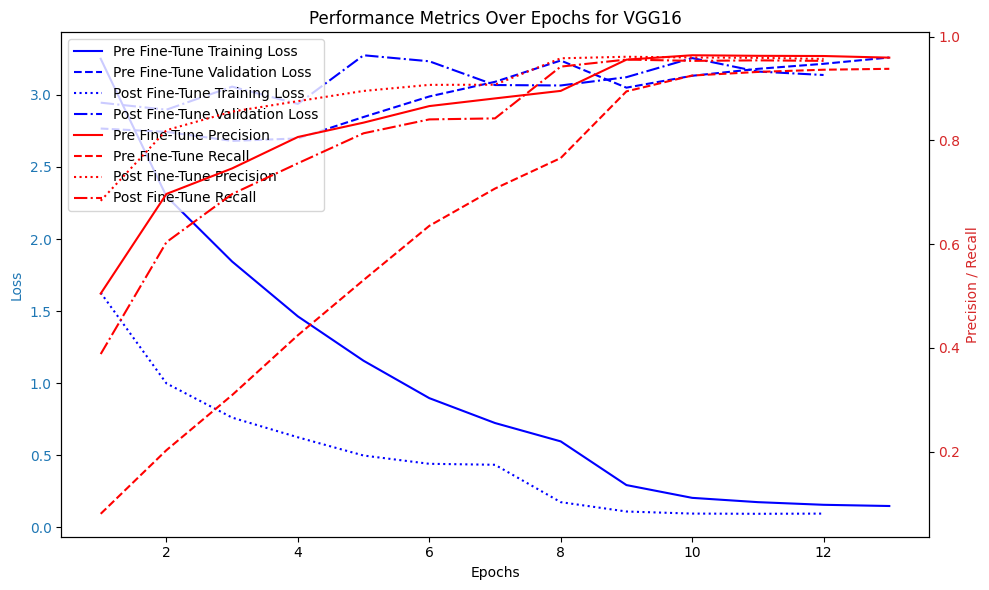

----------------------------------------
'Model: MobileNet'
----------------------------------------


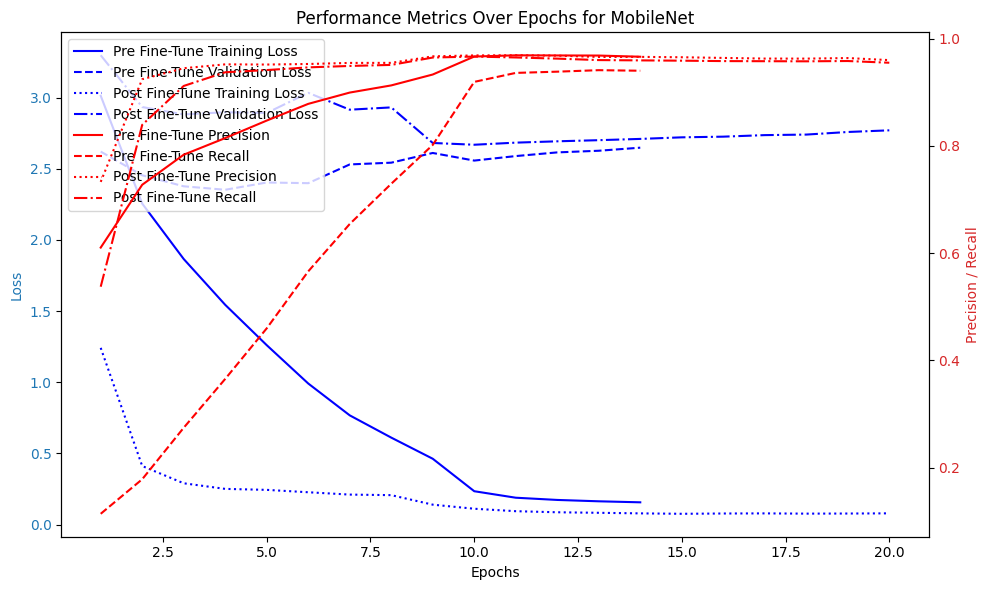

----------------------------------------
'Model: InceptionV3'
----------------------------------------


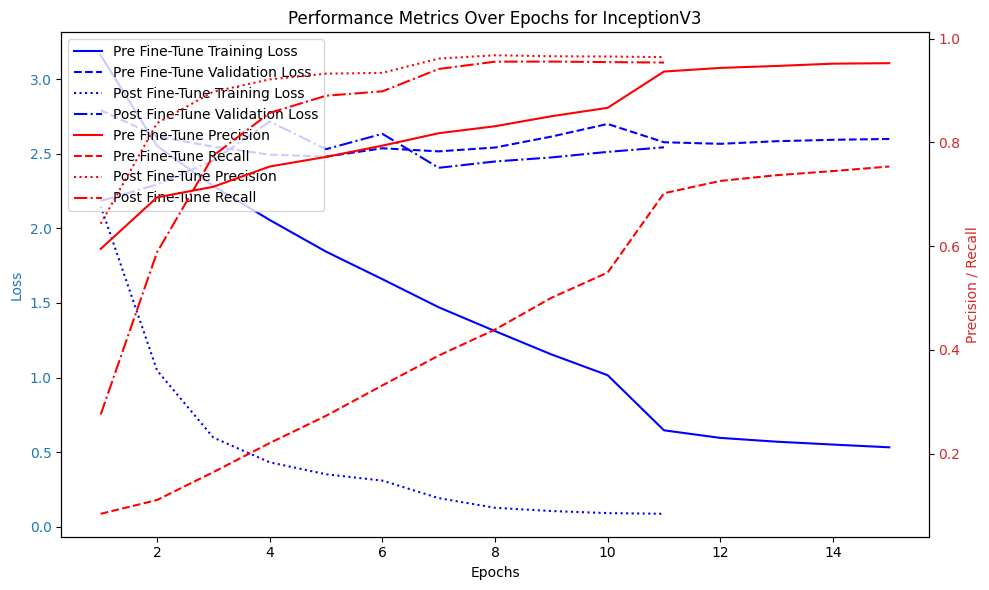

----------------------------------------
'Model: ResNet50'
----------------------------------------


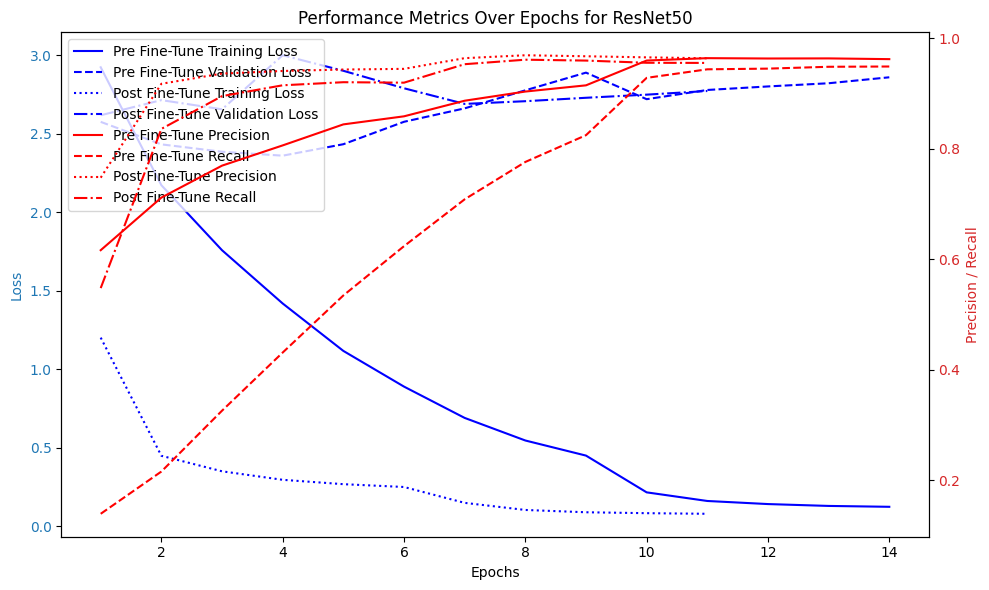

----------------------------------------
'Model: Xception'
----------------------------------------


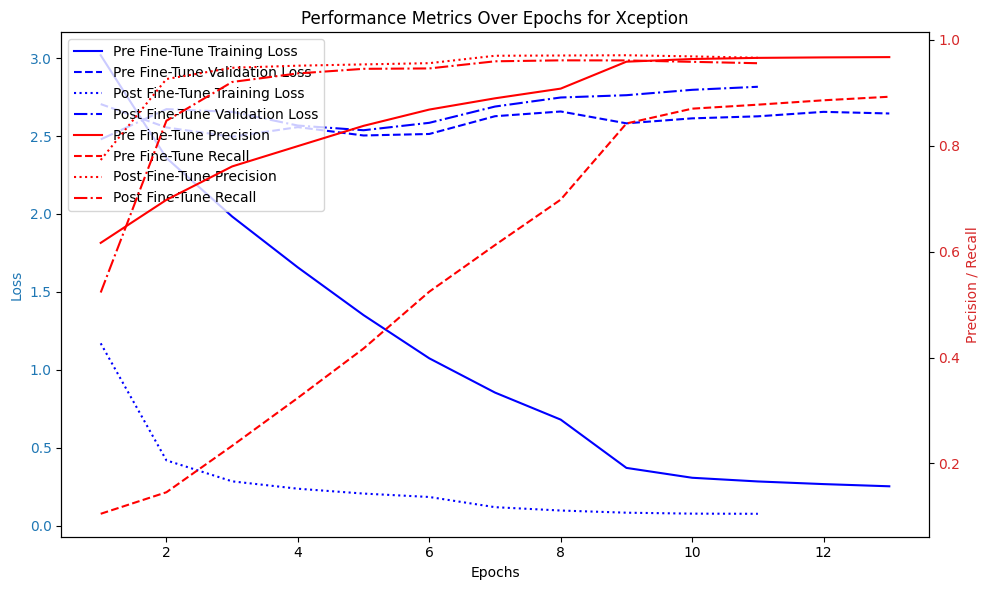

In [159]:
for modelName in global_pretrained_CNN_histories.keys():
    print("-"*40)
    print(f"'Model: {modelName}'")
    print("-"*40)
    plot_pretrained_model_performance(modelName, global_pretrained_CNN_histories[modelName])
    print("="*95)

### 8.4.6 Compare 'Train/Validation' Performance Metrics, over Epochs

In [160]:
# Import baseline model histories
with open('../03. Outputs/baseline_model_histories.json', 'r') as file:
    baseline_model_histories = json.load(file)
    
baseline_train_val_history_values = baseline_model_histories['train_val_history']
baseline_test_history_values = baseline_model_histories['test_history']

# Import custom CNN models histories
with open('../03. Outputs/custom_CNN_histories.json', 'r') as file:
    custom_CNN_histories = json.load(file)

In [161]:
cmap = plt.colormaps['rainbow']
models_to_color_count = len(global_pretrained_CNN_histories.keys()) + len(custom_CNN_histories.keys())
values = np.linspace(0, 1, models_to_color_count)
colors = cmap(values)
color_assign_tracker = 0

In [162]:
def plot_aggregate_metric(models_histories, metric, phase):
    plt.figure(figsize=(12, 6))
    color_assign_tracker = 0
    custom_metric_key = f'val_{metric}' if phase == 'validation' else metric
    for i in custom_CNN_histories.keys():
        custom_train_val_history_values = custom_CNN_histories[i]['train_val_history']
        custom_test_history_values = custom_CNN_histories[i]['test_history']
        custom_epochs = range(1, len(custom_train_val_history_values[custom_metric_key]) + 1)
        plt.plot(custom_epochs, custom_train_val_history_values[custom_metric_key], label=f"Custom Model:{custom_CNN_histories[i]['description']}", color=colors[color_assign_tracker % len(colors)], linestyle='-')
        color_assign_tracker += 1
    for i, (model_name, history) in enumerate(models_histories.items()):
        pre_fineTune_epochs = range(1, len(history['pre_fineTune'][metric]) + 1)
        post_fineTune_epochs = range(1, len(history['post_fineTune'][metric]) + 1)
        plt.plot(pre_fineTune_epochs, history['pre_fineTune'][metric], label=f'{model_name} Pre Fine-Tune', color=colors[color_assign_tracker % len(colors)], linestyle='--')
        plt.plot(post_fineTune_epochs, history['post_fineTune'][metric], label=f'{model_name} Post Fine-Tune', color=colors[color_assign_tracker % len(colors)], linestyle='-')
        color_assign_tracker += 1
    plt.title(f"{phase.capitalize()} '{metric.capitalize()}' over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

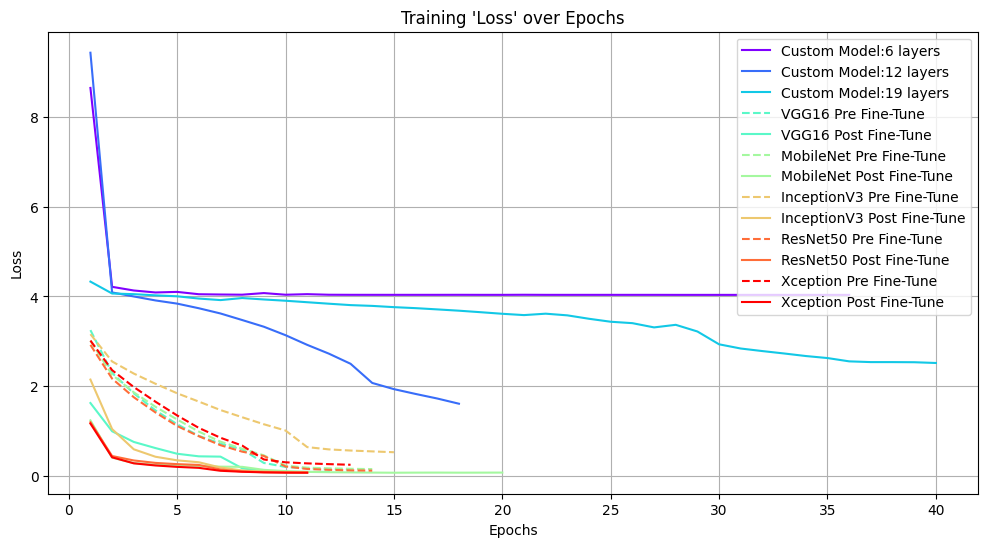

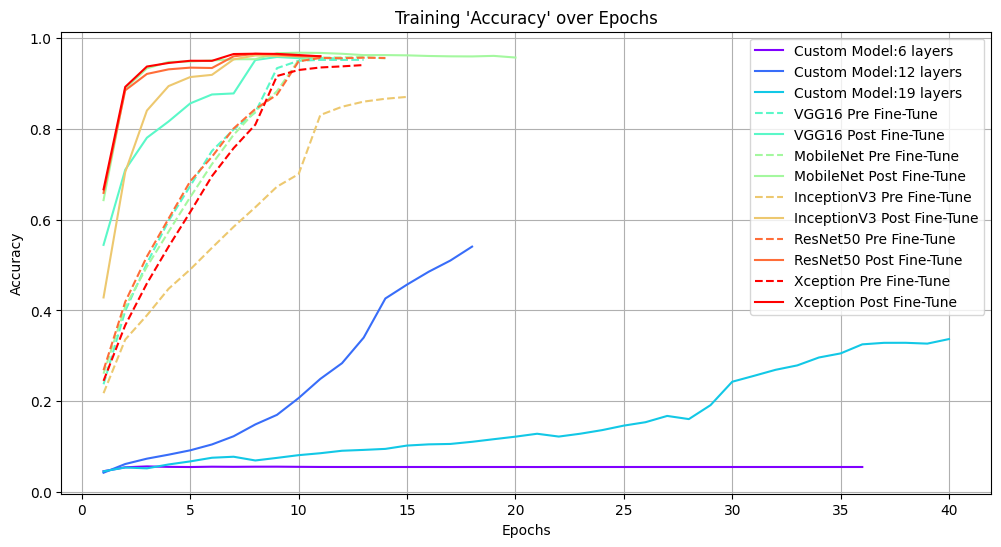

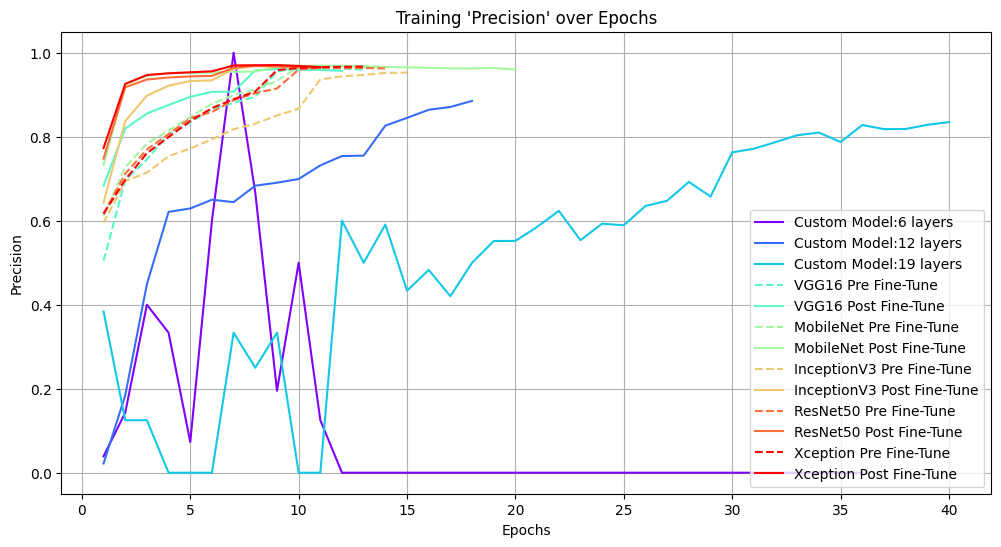

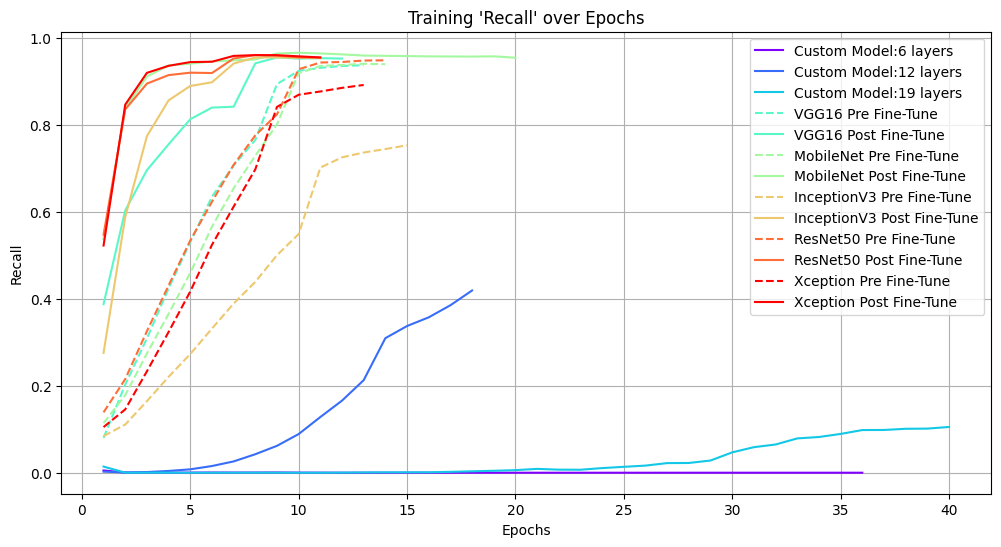

In [163]:
phase = 'training'
plot_aggregate_metric(global_pretrained_CNN_histories, 'loss', phase)
plot_aggregate_metric(global_pretrained_CNN_histories, 'accuracy', phase)
plot_aggregate_metric(global_pretrained_CNN_histories, 'precision', phase)
plot_aggregate_metric(global_pretrained_CNN_histories, 'recall', phase)

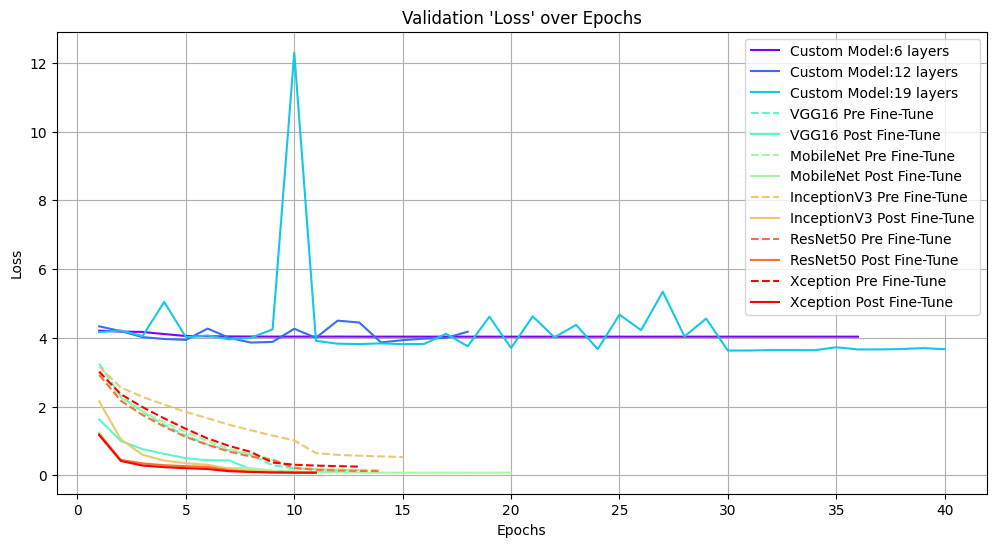

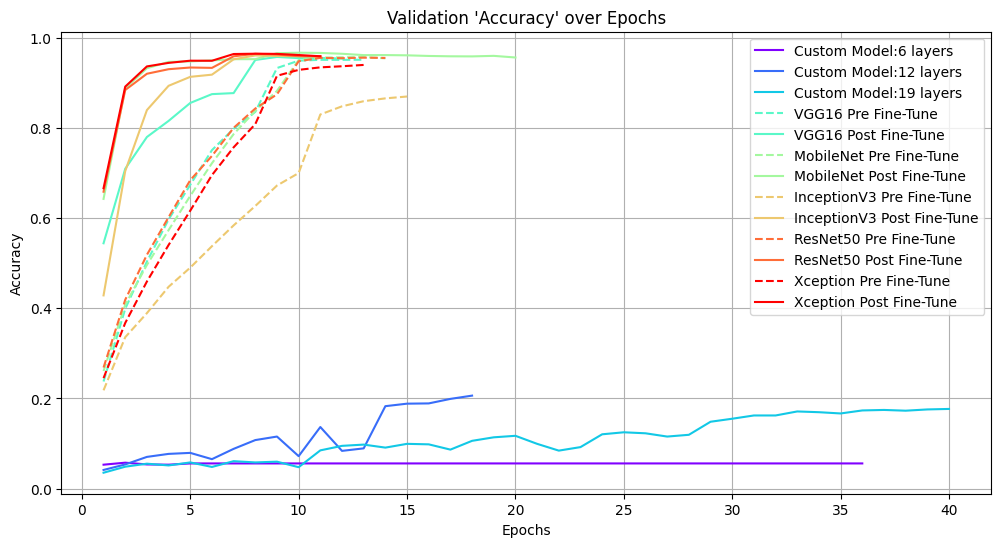

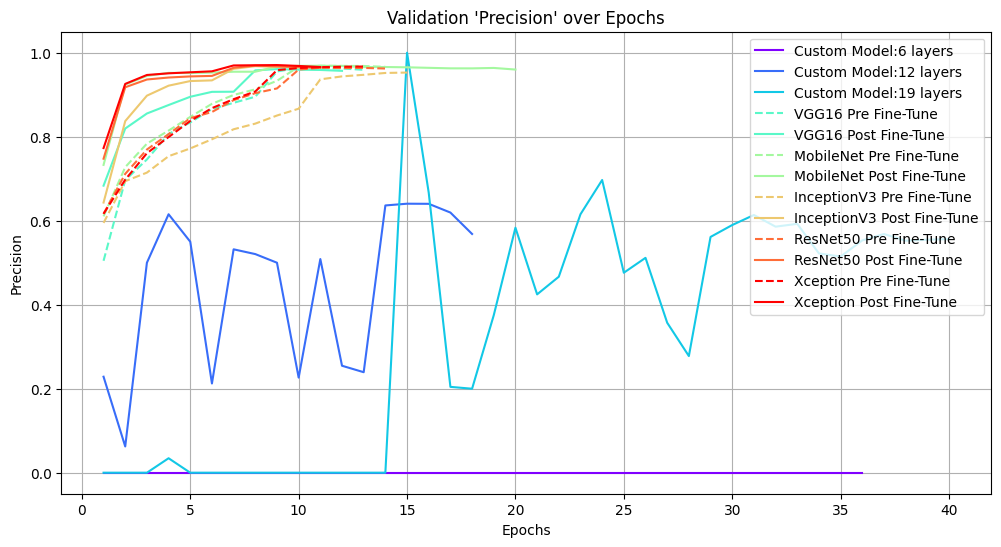

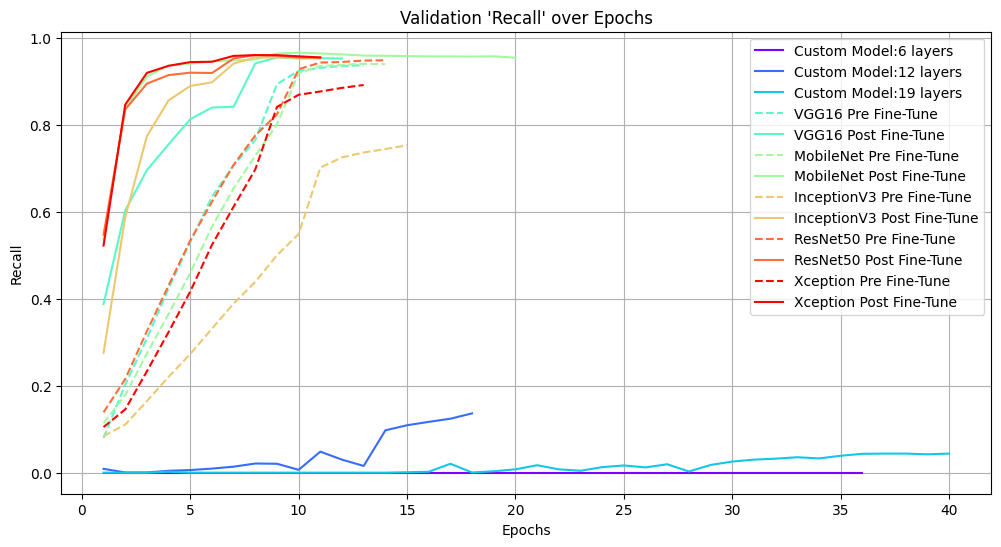

In [164]:
phase = 'validation'
plot_aggregate_metric(global_pretrained_CNN_histories, 'loss', phase)
plot_aggregate_metric(global_pretrained_CNN_histories, 'accuracy', phase)
plot_aggregate_metric(global_pretrained_CNN_histories, 'precision', phase)
plot_aggregate_metric(global_pretrained_CNN_histories, 'recall', phase)

### 8.4.7 Compare 'Test' Performance Metrics

Understand how well the model is performing for each individual class

In [165]:
def generate_classification_report(model_name):
    predictions = global_pretrained_test_predictions[model_name]["predictions"]
    true_labels = global_pretrained_test_predictions[model_name]["true_labels"]
    report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
    print(f"Classification Report:\n{report}")
    test_accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {test_accuracy:.4f}")

In [166]:
for model_name in global_pretrained_test_predictions:
    print("-"*40)
    print(f"Model: '{model_name}'")
    print("-"*40)
    generate_classification_report(model_name)
    print("="*95)

----------------------------------------
Model: 'VGG16'
----------------------------------------
Classification Report:
                                         precision    recall  f1-score   support

                   Acanthosis Nigricans       0.48      0.57      0.52        21
                        Acne Conglobata       0.54      0.50      0.52        38
                            Acne Keloid       0.56      0.67      0.61        42
                        Alopecia Areata       0.80      0.80      0.80        55
                   Arthritis, Psoriatic       0.73      0.65      0.69        17
                                Blister       0.26      0.14      0.18        42
                     Cafe-au-Lait Spots       0.54      0.61      0.57        33
                            Callosities       0.33      0.33      0.33         6
                              Carbuncle       0.40      0.33      0.36         6
                              Chloracne       1.00      0.33      0.5

Assess all evaluation metrics side-by-side

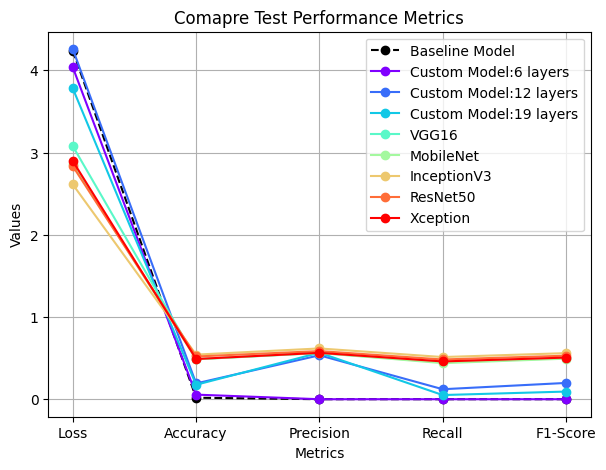

In [167]:
# Evaluation metrics
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(7, 5))
color_assign_tracker = 0
plt.plot(metrics, baseline_test_history_values, marker='o', color='black', label='Baseline Model', linestyle='--')
for i in custom_CNN_histories.keys():
    custom_test_history_values = custom_CNN_histories[i]['test_history']
    plt.plot(metrics, custom_test_history_values,marker='o', color=colors[color_assign_tracker % len(colors)], label=f"Custom Model:{custom_CNN_histories[i]['description']}", linestyle='-')
    color_assign_tracker += 1
models = list(global_pretrained_CNN_histories.keys())
for i, model in enumerate(models):
    pre_trained_history_values = global_pretrained_CNN_histories[model]['test_history']
    plt.plot(metrics, pre_trained_history_values, marker='o', color=colors[color_assign_tracker % len(colors)], label=model)
    color_assign_tracker += 1
plt.title('Comapre Test Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Assess `Loss` metric alone, across all pre-trained models

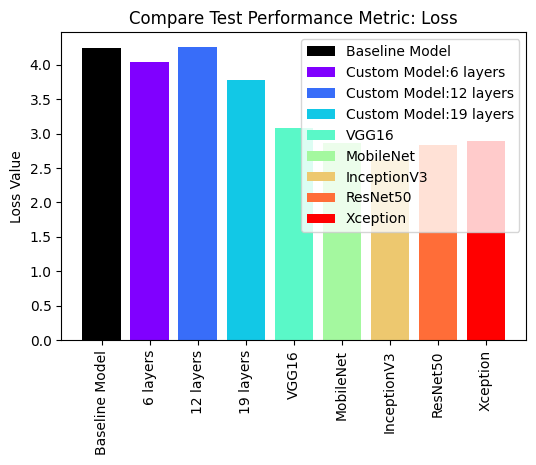

In [168]:
# Plot 'Loss' metric for baseline model
metrics = ['Loss']
plt.figure(figsize=(6, 4))
color_assign_tracker = 0
num_models = 1 + models_to_color_count
x_pos = np.arange(num_models)
plt.bar(x_pos[0], [baseline_test_history_values[0]], color='black', label='Baseline Model')
model_labels = ['Baseline Model']

# Plot 'Loss' metric for each custom model
for i in custom_CNN_histories.keys():
    custom_test_history_values = custom_CNN_histories[i]['test_history']
    plt.bar(x_pos[color_assign_tracker+1], [custom_test_history_values[0]], color=colors[color_assign_tracker % len(colors)], label=f"Custom Model:{custom_CNN_histories[i]['description']}")
    color_assign_tracker += 1
    model_labels.append(custom_CNN_histories[i]['description'])

# Plot 'Loss' metric for each pre-trained model
for i, model in enumerate(global_pretrained_CNN_histories.keys()):
    plt.bar(x_pos[color_assign_tracker+1], [global_pretrained_CNN_histories[model]['test_history'][0]], color=colors[color_assign_tracker % len(colors)], label=model)
    color_assign_tracker += 1
    model_labels.append(model)

plt.xticks(x_pos, model_labels, rotation=90)
plt.title('Compare Test Performance Metric: Loss')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

Assess `Accuracy`, `Precision`, `Recall`, `F1-Score` metrics, across all pre-trained models

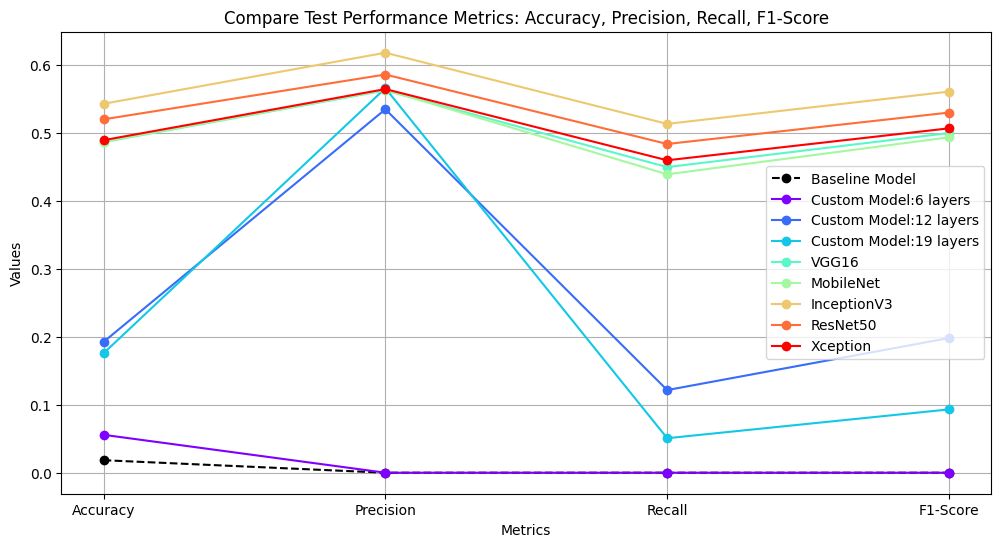

In [169]:
# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 6))
color_assign_tracker = 0

# Plot test metrics for baseline model
plt.plot(metrics, baseline_test_history_values[1:], marker='o', color='black', label='Baseline Model', linestyle='--')

# Plot test metrics for each custom model
for i in custom_CNN_histories.keys():
    custom_test_history_values = custom_CNN_histories[i]['test_history']
    plt.plot(metrics, custom_test_history_values[1:],marker='o', color=colors[color_assign_tracker % len(colors)], label=f"Custom Model:{custom_CNN_histories[i]['description']}", linestyle='-')
    color_assign_tracker += 1

# Plot test metrics for each pre-trained model
models = list(global_pretrained_CNN_histories.keys())
for i, model in enumerate(models):
    pre_trained_history_values = global_pretrained_CNN_histories[model]['test_history']
    plt.plot(metrics, pre_trained_history_values[1:], marker='o', color=colors[color_assign_tracker % len(colors)], label=model)
    color_assign_tracker += 1
    
plt.title('Compare Test Performance Metrics: Accuracy, Precision, Recall, F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()